In [2]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

root_dir = '/media/harish/SSD/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_ERA5.yaml'

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']

In [3]:
coeff = xr.open_dataset(Coeff_file)
ERA5 = xr.open_dataset(input_file)
CERRA = xr.open_dataset(f'{root_dir}/data/CERRA.nc')
times = coeff.time.values
times

array(['2017-03-23T12:00:00.000000000', '2017-03-23T13:00:00.000000000',
       '2017-03-23T14:00:00.000000000', ...,
       '2018-04-11T14:00:00.000000000', '2018-04-11T15:00:00.000000000',
       '2018-04-11T23:00:00.000000000'], dtype='datetime64[ns]')

In [4]:
# === exclude the nan rows from times ===
nan_rows = np.isnan(coeff['data'].values).any(axis=1)
times = times[~nan_rows]

# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T02:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-31T11:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T02:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T11:00:00','2018-01-05T04:00:00'],
                }
# get the dates into one list
profile_dates_list = []
for key in profile_dates.keys():
    profile_dates_list.append(profile_dates[key][0])
    profile_dates_list.append(profile_dates[key][1])

# convert dates into datetime64[ns]
profile_dates_list = np.array(profile_dates_list, dtype='datetime64[ns]')

# exclude dates from times
times = np.array([time for time in times if time not in profile_dates_list])

# Randomly divide times into training, validation, and testing by 70%, 20%, and 10%
np.random.seed(randSeed)
np.random.shuffle(times)
train_times = times[:int(0.7*len(times))]
valid_times = times[int(0.7*len(times)):int(0.9*len(times))]
test_times = times[int(0.9*len(times)):]
# add the profile_dates_list to test_times
test_times = np.concatenate([test_times, profile_dates_list])

In [5]:
X_train,Y_train = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,train_times,train_locations)
X_valid,Y_valid = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,valid_times,train_locations)
X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,test_times,train_locations)
print('Training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape)
print('Validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)
print('Testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

Training inputs shape: (4912, 24) training targets shape: (4912, 5)
Validation inputs shape: (1404, 24) validation targets shape: (1404, 5)
Testing inputs shape: (710, 24) testing targets shape: (710, 5)


In [6]:
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]
df_Obs = pd.read_csv(f'{root_dir}/data/Heligoland_wind.csv',index_col=0,parse_dates=True)
print(df_Obs.head())
# Resampling the data to hourly frequency, by averaging the values
#df_Obs = df_Obs.resample('H').mean() #['Obs_wind_speed']['ws_50_m']

                     ws_40_m  ws_50_m  ws_60_m  ws_70_m  ws_80_m  ws_90_m  \
2017-03-23 12:10:00     8.67     9.19     9.68    10.19    10.63    10.93   
2017-03-23 12:20:00     8.21     8.77     9.24     9.67    10.13    10.45   
2017-03-23 12:30:00     7.59     8.05     8.63     9.11     9.58    10.03   
2017-03-23 12:40:00     7.71     7.96     8.34     8.83     9.43    10.01   
2017-03-23 12:50:00     7.94     8.55     9.22     9.82    10.35    10.78   

                     ws_100_m  ws_120_m  ws_140_m  ws_160_m  ...  ws_260_m  \
2017-03-23 12:10:00     11.11     10.99     10.60     10.22  ...     10.26   
2017-03-23 12:20:00     10.69     10.92     10.91     10.72  ...     10.76   
2017-03-23 12:30:00     10.41     10.73     10.69     10.64  ...     11.28   
2017-03-23 12:40:00     10.53     11.06     11.10     11.06  ...     11.36   
2017-03-23 12:50:00     11.15     11.64     11.67     11.66  ...     11.45   

                     ws_280_m  ws_300_m  ws_320_m  ws_340_m  ws_360_

In [13]:
pretrained_experiment = '17Y'
experiment = 'Heligoland_retraining'
pretrained_run = 0
run = 0
Ens = 0
pretrained_OUTPUT_DIR = f'{root_dir}/WES/trained_models/{pretrained_experiment}/run_{pretrained_run}/Ens_{Ens}'
OUTPUT_DIR = f'{root_dir}/WES/trained_models/{experiment}/run_{run}/Ens_{Ens}'
os.system(f'mkdir -p {OUTPUT_DIR}')
# Load model
fSTR = f'TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
with open(f'{pretrained_OUTPUT_DIR}/{fSTR}', "rb") as f:
    tabReg = pickle.load(f)
    print(tabReg)
    #tabReg.save_model(f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}')

TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.4, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=1, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=600, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


In [8]:
import copy
tabReg = TabNetRegressor()
tabReg.load_model(f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.zip')
tabReg.optimizer_params['lr'] = 0.005
print(tabReg)

TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.4, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=1, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=600, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.005}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.22915 | train_rmse: 9.6918  | valid_rmse: 10.11569|  0:00:00s
epoch 1  | loss: 0.02308 | train_rmse: 9.36632 | valid_rmse: 9.4682  |  0:00:01s
epoch 2  | loss: 0.012   | train_rmse: 9.16359 | valid_rmse: 9.36254 |  0:00:02s
epoch 3  | loss: 0.0093  | train_rmse: 7.34215 | valid_rmse: 7.45125 |  0:00:02s
epoch 4  | loss: 0.00837 | train_rmse: 5.16882 | valid_rmse: 5.29309 |  0:00:03s
epoch 5  | loss: 0.00819 | train_rmse: 4.13819 | valid_rmse: 4.18128 |  0:00:04s
epoch 6  | loss: 0.00766 | train_rmse: 2.89976 | valid_rmse: 2.91836 |  0:00:05s
epoch 7  | loss: 0.00742 | train_rmse: 2.02085 | valid_rmse: 2.03557 |  0:00:05s
epoch 8  | loss: 0.00725 | train_rmse: 1.63689 | valid_rmse: 1.61696 |  0:00:06s
epoch 9  | loss: 0.00704 | train_rmse: 1.20844 | valid_rmse: 1.19085 |  0:00:07s
epoch 10 | loss: 0.00675 | train_rmse: 0.8606  | valid_rmse: 0.84984 |  0:00:07s
epoch 11 | loss: 0.00664 | train_rmse: 0.66217 | valid_rmse: 0.65545 |  0:00:08s
epoch 12 | loss: 0.00653 | t

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


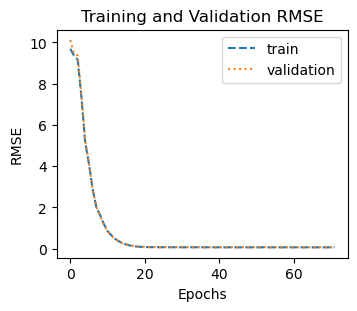

In [33]:
min_max_scaler = preprocessing.MinMaxScaler().fit(Y_train)
Y_train_trans = min_max_scaler.transform(Y_train)
Y_valid_trans = min_max_scaler.transform(Y_valid)

tabReg.fit(X_train=X_train, y_train=Y_train_trans,
                    eval_set=[(X_train, Y_train_trans), (X_valid, Y_valid_trans)],
                    eval_name=['train', 'valid'],
                    max_epochs=250, batch_size=256,    #bSize_opt.item(), 
                    eval_metric=['rmse'], patience=10,  #mae, rmse
                    loss_fn = torch.nn.MSELoss(),warm_start=True)

# --- Plot loss curve and hexbin ---
fig = plt.figure(figsize=(18, 3), constrained_layout=True)
gs = fig.add_gridspec(1,6)

# Line plot for train and validation RMSE
ax = fig.add_subplot(gs[0])
ax.plot(tabReg.history['train_rmse'],'--', label='train')
ax.plot(tabReg.history['valid_rmse'],':', label='validation')
ax.set_title('Training and Validation RMSE')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')
ax.legend()

In [ ]:
tabReg2   = tabReg


update_state_dict = copy.deepcopy(tabReg2.network.state_dict())
for param, weights in tabReg.network.state_dict().items():
    if param.startswith("encoder"):
        # Convert encoder's layers name to match
        new_param = "tabnet." + param
    else:
        new_param = param
    if tabReg2.network.state_dict().get(new_param) is not None:
        # update only common layers
        update_state_dict[new_param] = weights

tabReg2.network.load_state_dict(update_state_dict)

epoch 0  | loss: 0.00677 | train_rmse: 0.06771 | valid_rmse: 0.06918 |  0:00:00s
epoch 1  | loss: 0.00455 | train_rmse: 0.0653  | valid_rmse: 0.06665 |  0:00:01s
epoch 2  | loss: 0.00435 | train_rmse: 0.06406 | valid_rmse: 0.06534 |  0:00:02s
epoch 3  | loss: 0.00432 | train_rmse: 0.06368 | valid_rmse: 0.06495 |  0:00:02s
epoch 4  | loss: 0.00425 | train_rmse: 0.0638  | valid_rmse: 0.06503 |  0:00:03s
epoch 5  | loss: 0.00422 | train_rmse: 0.06348 | valid_rmse: 0.06483 |  0:00:04s
epoch 6  | loss: 0.00422 | train_rmse: 0.06331 | valid_rmse: 0.06437 |  0:00:05s
epoch 7  | loss: 0.00425 | train_rmse: 0.06304 | valid_rmse: 0.06425 |  0:00:05s
epoch 8  | loss: 0.00418 | train_rmse: 0.06308 | valid_rmse: 0.06414 |  0:00:06s
epoch 9  | loss: 0.00422 | train_rmse: 0.06295 | valid_rmse: 0.06409 |  0:00:07s
epoch 10 | loss: 0.00415 | train_rmse: 0.0628  | valid_rmse: 0.06417 |  0:00:08s
epoch 11 | loss: 0.00415 | train_rmse: 0.06268 | valid_rmse: 0.0639  |  0:00:08s
epoch 12 | loss: 0.00413 | t

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


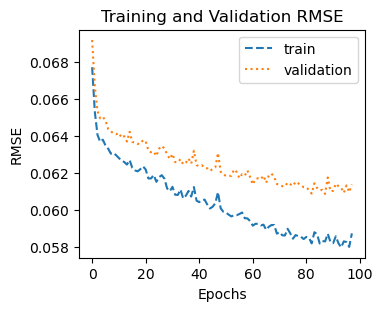

In [14]:
tabReg.optimizer_params['lr'] = 0.005
min_max_scaler = preprocessing.MinMaxScaler().fit(Y_train)
Y_train_trans = min_max_scaler.transform(Y_train)
Y_valid_trans = min_max_scaler.transform(Y_valid)

tabReg.fit(X_train=X_train, y_train=Y_train_trans,
                    eval_set=[(X_train, Y_train_trans), (X_valid, Y_valid_trans)],
                    eval_name=['train', 'valid'],
                    max_epochs=250, batch_size=256,    #bSize_opt.item(), 
                    eval_metric=['rmse'], patience=10,  #mae, rmse
                    loss_fn = torch.nn.MSELoss(),
                    warm_start=True,)

# --- Plot loss curve and hexbin ---
fig = plt.figure(figsize=(18, 3), constrained_layout=True)
gs = fig.add_gridspec(1,6)

# Line plot for train and validation RMSE
ax = fig.add_subplot(gs[0])
ax.plot(tabReg.history['train_rmse'],'--', label='train')
ax.plot(tabReg.history['valid_rmse'],':', label='validation')
ax.set_title('Training and Validation RMSE')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')
ax.legend()

In [15]:
obs_levels = np.array([40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500])
CERRA_levels = np.array([10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.])
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,X_test,Y_test,Obs=None,date=None,title=None,xlabel=None,ylabel=None):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[0,0:2]
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate cerra profile
    M_true = WindProfile(Z, Y_test[0,:])
    axs.plot(M_true, Z, '-k', linewidth=2, markerfacecolor='r', label='CERRA')

    if Obs is not None:
        axs.plot(Obs,obs_levels, '--r', linewidth=2, markerfacecolor='r',label='Obs')

        Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test))
        Mp = WindProfile(Z, Y_pred[0, :])


    # Plot median
    axs.plot(Mp, Z, linestyle='-', linewidth=2, label='Ensemble (p50)')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])

    if title is not None:
        axs.set_title(title)

    if xlabel is not None:
        axs.set_xlabel(xlabel)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    return axs

0 High shear 2017-10-17T02:00:00
0 Low shear/well mixed 2017-05-31T11:00:00
0 LLJ 2018-04-10T02:00:00
0 High wind 2017-12-31T11:00:00


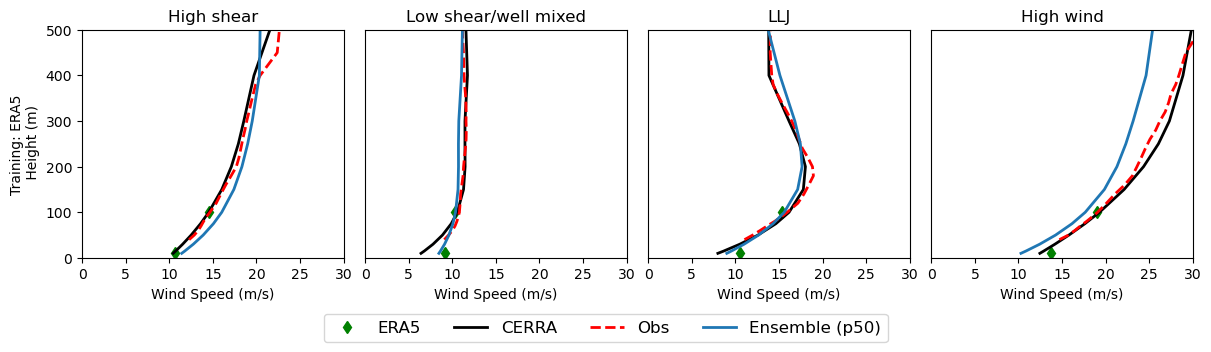

In [16]:
# best profiles
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][0])

    X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
    Obs = df_Obs[profile_dates[profile][0]:profile_dates[profile][0]].values.T

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

0 High shear 2017-06-06T10:00:00
0 Low shear/well mixed 2017-11-20T13:00:00
0 LLJ 2017-03-30T02:00:00
0 High wind 2018-01-05T04:00:00


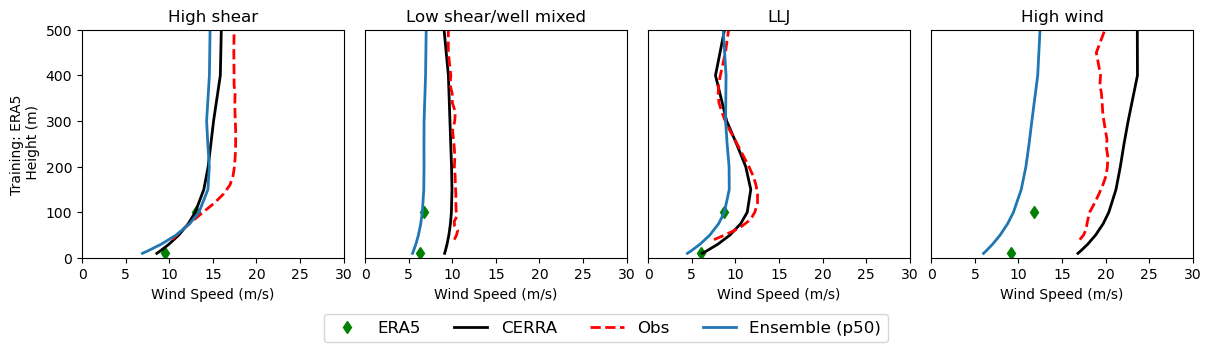

In [17]:
# worst profiles
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][1])

    X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    X_test,Y_test = data_processing(input_file,f'{root_dir}/data/Chebyshev_Coefficnents.nc',input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    Obs = df_Obs[profile_dates[profile][1]:profile_dates[profile][1]].values.T

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)